# Before you use this template

This template is just a recommended template for project Report. It only considers the general type of research in our paper pool. Feel free to edit it to better fit your project. You will iteratively update the same notebook submission for your draft and the final submission. Please check the project rubriks to get a sense of what is expected in the template.

---

# FAQ and Attentions
* Copy and move this template to your Google Drive. Name your notebook by your team ID (upper-left corner). Don't eidt this original file.
* This template covers most questions we want to ask about your reproduction experiment. You don't need to exactly follow the template, however, you should address the questions. Please feel free to customize your report accordingly.
* any report must have run-able codes and necessary annotations (in text and code comments).
* The notebook is like a demo and only uses small-size data (a subset of original data or processed data), the entire runtime of the notebook including data reading, data process, model training, printing, figure plotting, etc,
must be within 8 min, otherwise, you may get penalty on the grade.
  * If the raw dataset is too large to be loaded  you can select a subset of data and pre-process the data, then, upload the subset or processed data to Google Drive and load them in this notebook.
  * If the whole training is too long to run, you can only set the number of training epoch to a small number, e.g., 3, just show that the training is runable.
  * For results model validation, you can train the model outside this notebook in advance, then, load pretrained model and use it for validation (display the figures, print the metrics).
* The post-process is important! For post-process of the results,please use plots/figures. The code to summarize results and plot figures may be tedious, however, it won't be waste of time since these figures can be used for presentation. While plotting in code, the figures should have titles or captions if necessary (e.g., title your figure with "Figure 1. xxxx")
* There is not page limit to your notebook report, you can also use separate notebooks for the report, just make sure your grader can access and run/test them.
* If you use outside resources, please refer them (in any formats). Include the links to the resources if necessary.

# Mount Notebook to Google Drive
Upload the data, pretrianed model, figures, etc to your Google Drive, then mount this notebook to Google Drive. After that, you can access the resources freely.

Instruction: https://colab.research.google.com/notebooks/io.ipynb

Example: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q

Video: https://www.youtube.com/watch?v=zc8g8lGcwQU

# Preprocessing of Data

## Select records with ICD-VERSION = 10 from diagnosis_icd.csv

In [1]:
import csv
import pandas as pd
import torch


data_df = pd.read_csv('./mimic-iv-2.2/hosp/diagnoses_icd.csv.gz', nrows=None, compression='gzip',
            dtype={'subject_id': str, 'hadm_id': str, 'icd_code': str, 'icd_version': str},
            on_bad_lines='skip')


# Select records with ICD-VERSION =10

data_df_icd_10 = data_df[data_df['icd_version'] == "10"]

dir_path = './mimic-iv-2.2/hosp/diagnosis_icd10.csv'

data_df_icd_10.to_csv(dir_path, index=False)

print('After preprocessing Data in diagnosis_icd')
print(data_df_icd_10.iloc[:3])


After preprocessing Data in diagnosis_icd
   subject_id   hadm_id  seq_num icd_code icd_version
40   10000084  23052089        1    G3183          10
41   10000084  23052089        2    F0280          10
42   10000084  23052089        3     R441          10


# In Below Section we'll be showing 3 models:

## Model-1 : Run Multilabel prediction using dataset with feature keys: Diagnosis code, procedure code and drugs prescribed.
## Model-2 : Run Multilabel prediction using dataset with feature key - Diagnosis code.
## Model-3 : Run Binary prediction using dataset with feature key - Diagnosis code.

# Dataset Preparation

In [2]:
import warnings
warnings.filterwarnings('ignore')

from pyhealth.datasets import MIMIC4Dataset

# Dataset with information such as diagnosis code, procedure code, prescription history of past visits of patients

In [3]:
# Dataset with Diagnosis code, procedure code and drugs prescribed
mimic4_ds = MIMIC4Dataset(
        root="./mimic-iv-2.2/hosp",
        tables=["diagnoses_icd", "procedures_icd", "prescriptions"],
        code_mapping={"NDC": ("ATC")},
        refresh_cache=False,
)

# Show the statistics below.
mimic4_ds.stat()


Statistics of base dataset (dev=False):
	- Dataset: MIMIC4Dataset
	- Number of patients: 180733
	- Number of visits: 431231
	- Number of visits per patient: 2.3860
	- Number of events per visit in diagnoses_icd: 4.6134
	- Number of events per visit in procedures_icd: 1.5518
	- Number of events per visit in prescriptions: 54.2354



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC4Dataset\n\t- Number of patients: 180733\n\t- Number of visits: 431231\n\t- Number of visits per patient: 2.3860\n\t- Number of events per visit in diagnoses_icd: 4.6134\n\t- Number of events per visit in procedures_icd: 1.5518\n\t- Number of events per visit in prescriptions: 54.2354\n'

# Dataset with information such as - diagnosis code history of past visits of patients

In [4]:
# Dataset with Diagnosis code
mimic4_ds_diag = MIMIC4Dataset(
        root="./mimic-iv-2.2/hosp",
        tables=["diagnoses_icd"],
        refresh_cache=False,
)

# Show the statistics below.
mimic4_ds_diag.stat()


Statistics of base dataset (dev=False):
	- Dataset: MIMIC4Dataset
	- Number of patients: 180733
	- Number of visits: 431231
	- Number of visits per patient: 2.3860
	- Number of events per visit in diagnoses_icd: 4.6134



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC4Dataset\n\t- Number of patients: 180733\n\t- Number of visits: 431231\n\t- Number of visits per patient: 2.3860\n\t- Number of events per visit in diagnoses_icd: 4.6134\n'

# Task Functions

## Task Function 1 - Task Function for diagnosis recommendation.
## This function will create dataset sample to be used in diagnosis recommendation of future visits using past visit's history.

In [5]:
def condition_recommendation_mimic4_fn(patient):
    samples = []
    for visit in patient:

        # step 1: obtain visit-level information, conditions, procedures, and drugs
        conditions = visit.get_code_list(table="diagnoses_icd")
        procedures = visit.get_code_list(table="procedures_icd")
        drugs = visit.get_code_list(table="prescriptions")
      
        # step 2: exclusion criteria: cohort selection
        if len(conditions) * len(procedures) * len(drugs) == 0: continue

        # step 3: assemble the sample
        # REMEMBER: the key here will be the "feature_keys" and "label_key" for initializing the downstream model
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "condition_hist": conditions,
                "procedures": procedures,
                "drugs": drugs,
                "condition": conditions,
            }
        )

    # step 4: patient-level cohort selection and other process
    # exclude patients with less than 2 visit
    if len(samples) < 2:
        return []

    """ 
    Add historical visit (use "conditions" key as an example)
        before this step:
            samples[0]["conditions"]: 1st visit
            samples[1]["conditions"]: 2nd visit
            samples[2]["conditions"]: 3rd visit
            ...
        
        after this step:
            samples[0]["conditions"]: [1st visit]
            samples[1]["conditions"]: [1st visit, 2nd visit]
            samples[2]["conditions"]: [1st visit, 2nd visit, 3rd visit]
            ...
    """
    # Note - For first visit - condition and condition history both will be empty list
    samples[0]["condition"] = []
    samples[0]["condition_hist"] = [samples[0]["condition_hist"]]
    samples[0]["procedures"] = [samples[0]["procedures"]]
    samples[0]["drugs"] = [samples[0]["drugs"]]

    for i in range(1, len(samples)):
        samples[i]["condition_hist"] = samples[i - 1]["condition_hist"] + [
            samples[i]["condition_hist"]
        ]
        samples[i]["procedures"] = samples[i - 1]["procedures"] + [
            samples[i]["procedures"]
        ]
        samples[i]["drugs"] = samples[i - 1]["drugs"] + [
            samples[i]["drugs"]
        ]
 
    for i in range(len(samples)):
        samples[i]["condition_hist"][i] = []

    return samples

## Task Function 2 - Task Function for diagnosis recommendation using only history of diagnosis from past visits..
## This function will create dataset sample to be used in diagnosis recommendation of future visits using past visit's history.

In [6]:
def condition_recommendation_mimic4_fn_diag(patient):
    samples = []
    for visit in patient:

        # step 1: obtain visit-level information, conditions, procedures, and drugs
        conditions = visit.get_code_list(table="diagnoses_icd")

        # step 2: exclusion criteria: cohort selection
        if len(conditions) == 0: continue

        # step 3: assemble the sample
        # REMEMBER: the key here will be the "feature_keys" and "label_key" for initializing the downstream model
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "condition_hist": conditions,
                "condition": conditions,
            }
        )

    # step 4: patient-level cohort selection and other process
    # exclude patients with less than 2 visit
    if len(samples) < 2:
        return []

    """ 
    Add historical visit (use "conditions" key as an example)
        before this step:
            samples[0]["conditions"]: 1st visit
            samples[1]["conditions"]: 2nd visit
            samples[2]["conditions"]: 3rd visit
            ...
        
        after this step:
            samples[0]["conditions"]: [1st visit]
            samples[1]["conditions"]: [1st visit, 2nd visit]
            samples[2]["conditions"]: [1st visit, 2nd visit, 3rd visit]
            ...
    """
    # Note - For first visit - condition and condition history both will be empty list
    samples[0]["condition"] = []
    samples[0]["condition_hist"] = [samples[0]["condition_hist"]]

    for i in range(1, len(samples)):
        samples[i]["condition_hist"] = samples[i - 1]["condition_hist"] + [
            samples[i]["condition_hist"]
        ]

    for i in range(len(samples)):
        samples[i]["condition_hist"][i] = []

    return samples

## Task Function 3 - Task Function for diagnosis recommendation related to Pancreatic Cancer using only history of diagnosis from past visits.
## This function will create dataset sample to be used in diagnosis recommendation of future visits using past visit's history.

In [7]:
def condition_recommendation_mimic4_fn_diag_c25(patient):
    samples = []
    for visit in patient:

        # step 1: obtain visit-level information, conditions, procedures, and drugs
        conditions = visit.get_code_list(table="diagnoses_icd")

        c25_cond = 0

        for condition in conditions:
            if condition[:3] != 'C25': continue
            else:
                c25_cond = 1


        # step 2: exclusion criteria: cohort selection
       
        if len(conditions) == 0: continue
            

        # step 3: assemble the sample
        # REMEMBER: the key here will be the "feature_keys" and "label_key" for initializing the downstream model
        # Set label to True if any diagnosis code start with 'C25' present in visit history.
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "condition_hist": conditions,
                "label": c25_cond,
            }
        )

    # step 4: patient-level cohort selection and other process
    # exclude patients with less than 2 visit
    if len(samples) < 2:
        return []

    """ 
    Add historical visit (use "conditions" key as an example)
        before this step:
            samples[0]["conditions"]: 1st visit
            samples[1]["conditions"]: 2nd visit
            samples[2]["conditions"]: 3rd visit
            ...
        
        after this step:
            samples[0]["conditions"]: [1st visit]
            samples[1]["conditions"]: [1st visit, 2nd visit]
            samples[2]["conditions"]: [1st visit, 2nd visit, 3rd visit]
            ...
    """

    samples[0]["condition_hist"] = [samples[0]["condition_hist"]]

    for i in range(1, len(samples)):
        samples[i]["condition_hist"] = samples[i - 1]["condition_hist"] + [
            samples[i]["condition_hist"]
        ]

    return samples

## Task Functions to create Test Datasets 

## Task Function 4 - Task Function for diagnosis recommendation related to Pancreatic Cancer using history of Diagnosis, Procedure and Drugs Prescribed from past visits.
## This function will create test dataset sample to be used in diagnosis recommendation of future visits using past visit's history.

In [8]:
def condition_recommendation_mimic4_fn_c25(patient):
    samples = []
    for visit in patient:

        # step 1: obtain visit-level information, conditions, procedures, and drugs
        conditions = visit.get_code_list(table="diagnoses_icd")
        procedures = visit.get_code_list(table="procedures_icd")
        drugs = visit.get_code_list(table="prescriptions")

        # step 2: Select visits with diagnosis code starts with C25
        c25_cond ='n'

        for condition in conditions:
            if condition[:3] != 'C25': continue
            else:
                c25_cond = 'y'
        if c25_cond == 'n':
            conditions = []


        # step 3: exclusion criteria: cohort selection

        if len(conditions) * len(procedures) * len(drugs) == 0: continue

        # step 4: assemble the sample
        # REMEMBER: the key here will be the "feature_keys" and "label_key" for initializing the downstream model
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "condition_hist": conditions,
                "procedures": procedures,
                "drugs": drugs,
                "condition": conditions,
            }
        )

    # step 5: patient-level cohort selection and other process
    # exclude patients with less than 2 visit
    if len(samples) < 2:
        return []

    """ 
    Add historical visit (use "conditions" key as an example)
        before this step:
            samples[0]["conditions"]: 1st visit
            samples[1]["conditions"]: 2nd visit
            samples[2]["conditions"]: 3rd visit
            ...
        
        after this step:
            samples[0]["conditions"]: [1st visit]
            samples[1]["conditions"]: [1st visit, 2nd visit]
            samples[2]["conditions"]: [1st visit, 2nd visit, 3rd visit]
            ...
    """
    samples[0]["condition"] = []
    samples[0]["condition_hist"] = [samples[0]["condition_hist"]]
    samples[0]["procedures"] = [samples[0]["procedures"]]
    samples[0]["drugs"] = [samples[0]["drugs"]]

    for i in range(1, len(samples)):
        samples[i]["condition_hist"] = samples[i - 1]["condition_hist"] + [
            samples[i]["condition_hist"]
        ]
        samples[i]["procedures"] = samples[i - 1]["procedures"] + [
            samples[i]["procedures"]
        ]
        samples[i]["drugs"] = samples[i - 1]["drugs"] + [
            samples[i]["drugs"]
        ]

    for i in range(len(samples)):
        samples[i]["condition_hist"][i] = []

    return samples

## Task Function 5 - Task Function for diagnosis recommendation related to Pancreatic Cancer using only history of diagnosis from past visits. This will add data samples with and without Pancreatic Cancer Diagnosis. So that model performance will be done more accurately.
## This function will create test dataset sample to be used in diagnosis recommendation of future visits using past visit's history.

In [9]:
def condition_recommendation_mimic4_fn_c25_test(patient):
    samples = []

    for visit in patient:

        # step 1: obtain visit-level information, conditions, procedures, and drugs
        conditions = visit.get_code_list(table="diagnoses_icd")

        # step 2: Select mixed samples. 
        #   Select visit data with atleast 2 visits has diagnosis code starts with 'C25'. 

        c25_cond =0

        if len(samples) < 3:

            for condition in conditions:
                if condition[:3] != 'C25': continue
                else:
                    c25_cond = 1
            if c25_cond == 0:
                conditions = []


        # step 3: exclusion criteria: cohort selection
        if len(conditions) == 0: continue

        # step 3: assemble the sample
        # REMEMBER: the key here will be the "feature_keys" and "label_key" for initializing the downstream model
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "condition_hist": conditions,
                "label": c25_cond,
            }
        )

    # step 4: patient-level cohort selection and other process
    # exclude patients with less than 2 visit
    if len(samples) < 2:
        return []

    """ 
    Add historical visit (use "conditions" key as an example)
        before this step:
            samples[0]["conditions"]: 1st visit
            samples[1]["conditions"]: 2nd visit
            samples[2]["conditions"]: 3rd visit
            ...
        
        after this step:
            samples[0]["conditions"]: [1st visit]
            samples[1]["conditions"]: [1st visit, 2nd visit]
            samples[2]["conditions"]: [1st visit, 2nd visit, 3rd visit]
            ...
    """

    samples[0]["condition_hist"] = [samples[0]["condition_hist"]]
    
    for i in range(1, len(samples)):
        samples[i]["condition_hist"] = samples[i - 1]["condition_hist"] + [
            samples[i]["condition_hist"] ]

    return samples


# Create Training, Valuation and Test Datasets and Dataloaders

## Create datasets and dataloaders for Model - 1 using Task Function 1 - "condition_recommendation_mimic4_fn"

In [10]:
import numpy as np
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader

np.random.seed(1234)

In [11]:
dataset = mimic4_ds.set_task(task_fn=condition_recommendation_mimic4_fn)

print ('For Model 1 - Sample data 1')
print(dataset.samples[1])
print ('For Model 1 - Sample data 2')
print(dataset.samples[2])

# data split
train_dataset, val_dataset, test_dataset = split_by_patient(dataset, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=64, shuffle=False)

Generating samples for condition_recommendation_mimic4_fn: 100%|████████████████████████████████████████████████████████████| 180733/180733 [00:47<00:00, 3820.66it/s]


For Model 1 - Sample data 1
{'visit_id': '26840593', 'patient_id': '10001401', 'condition_hist': [['C675', 'I10', 'D259', 'Z87891', 'E785', 'E890'], []], 'procedures': [['0TTB4ZZ', '07BC4ZX', '0UT9FZZ', '0UTC7ZZ', '0UT2FZZ', '0UBG4ZZ', '0T1807C', '8E0W4CZ'], ['02HV33Z', '3E0436Z', '0W9J30Z']], 'drugs': [['B01AB01', 'A06AA02', 'N02BE01', 'G01AF20', 'N02AA01', 'M01AB15', 'J01XD01', 'J01DB04', 'A04AA01', 'H03AA01', 'B05BA03', 'C05BB56', 'N02AA05', 'N02AA03', 'C10AA05', 'A02BC02', 'B01AB05', 'R02AX02', 'M01AE01', 'A02AB01', 'A02AB02', 'A02AA04', 'G04BX01', 'A06AB02', 'A06AD10', 'A06AG02', 'R06AD02', 'B05XA03', 'N02BE05', 'D08AE03', 'R02AD01', 'J01XE01'], ['B01AB05', 'B05BA03', 'C05BB56', 'H03AA01', 'B01AB01', 'C01BB01', 'N02BE01', 'N02BE05', 'A02BC02', 'D08AE03', 'C05AD01', 'D04AB01', 'N05BA06', 'N02AA03', 'A03FA01', 'M01AB15', 'B05XA03', 'J01DD04', 'A06AB02', 'A06AD10', 'A06AG02', 'A02BC01', 'J01EE01', 'A06AA02', 'J01MA02', 'A06AB06', 'P01AB01', 'A09AA01', 'A08AA56', 'G04BE52', 'N02AA59',

## Create datasets and dataloaders for Model - 2 using Task Function 2 - "condition_recommendation_mimic4_fn_diag"

In [12]:
dataset_diag = mimic4_ds_diag.set_task(task_fn=condition_recommendation_mimic4_fn_diag)

print ('For Model 2 - Sample data 1')
print(dataset_diag.samples[1])
print ('For Model 2 - Sample data 2')
print(dataset_diag.samples[2])

# data split
train_dataset_diag, val_dataset_diag, test_dataset_diag = split_by_patient(dataset_diag, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader_diag = get_dataloader(train_dataset_diag, batch_size=64, shuffle=True)
val_loader_diag = get_dataloader(val_dataset_diag, batch_size=64, shuffle=False)
test_loader_diag = get_dataloader(test_dataset_diag, batch_size=64, shuffle=False)

Generating samples for condition_recommendation_mimic4_fn_diag: 100%|█████████████████████████████████████████████████████| 180733/180733 [00:01<00:00, 124644.90it/s]


For Model 2 - Sample data 1
{'visit_id': '29888819', 'patient_id': '10000084', 'condition_hist': [['G3183', 'F0280', 'R441', 'R296', 'E785', 'Z8546'], []], 'condition': ['R4182', 'G20', 'F0280', 'R609', 'E785', 'Z8546']}
For Model 2 - Sample data 2
{'visit_id': '22927623', 'patient_id': '10000117', 'condition_hist': [[]], 'condition': []}


## Create datasets and dataloaders for Model - 3 using Task Function 3 - "condition_recommendation_mimic4_fn_diag_c25"

In [13]:
dataset_diag_c25 = mimic4_ds_diag.set_task(task_fn=condition_recommendation_mimic4_fn_diag_c25)


print ('For Model 3 - Sample data 1')
print(dataset_diag_c25.samples[1])
print ('For Model 3 - Sample data 2')
print(dataset_diag_c25.samples[2])

# data split
train_dataset_diag_c25, val_dataset_diag_c25, test_dataset_diag_c25 = split_by_patient(dataset_diag_c25, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader_diag_c25 = get_dataloader(train_dataset_diag_c25, batch_size=64, shuffle=True)
val_loader_diag_c25 = get_dataloader(val_dataset_diag_c25, batch_size=64, shuffle=False)
test_loader_diag_c25 = get_dataloader(test_dataset_diag_c25, batch_size=64, shuffle=False)

Generating samples for condition_recommendation_mimic4_fn_diag_c25: 100%|█████████████████████████████████████████████████| 180733/180733 [00:00<00:00, 216526.82it/s]


For Model 3 - Sample data 1
{'visit_id': '29888819', 'patient_id': '10000084', 'condition_hist': [['G3183', 'F0280', 'R441', 'R296', 'E785', 'Z8546'], ['R4182', 'G20', 'F0280', 'R609', 'E785', 'Z8546']], 'label': 0}
For Model 3 - Sample data 2
{'visit_id': '22927623', 'patient_id': '10000117', 'condition_hist': [['R1310', 'R0989', 'K31819', 'K219', 'K449', 'F419', 'I341', 'M810', 'Z87891']], 'label': 0}


## Create Test datasets and dataloaders for Model - 1 using Task Function 4 - "condition_recommendation_mimic4_fn_c25"

In [14]:
dataset_c25 = mimic4_ds.set_task(task_fn=condition_recommendation_mimic4_fn_c25)

print ('For Model 1 - Sample Test data 1')
print(dataset_c25.samples[1])
print('Test Sample size: ', len(dataset_c25))

test_loader_c25 = get_dataloader(dataset_c25, batch_size=64, shuffle=False)

Generating samples for condition_recommendation_mimic4_fn_c25: 100%|███████████████████████████████████████████████████████| 180733/180733 [00:05<00:00, 35676.70it/s]

For Model 1 - Sample Test data 1
{'visit_id': '25589898', 'patient_id': '10006431', 'condition_hist': [['G893', 'Z66', 'K8580', 'E43', 'C250', 'C787', 'C7900', 'I959', 'K219', 'Z681', 'I10', 'E049', 'E7800', 'K5900'], []], 'procedures': [['3E0T3GC'], ['0FBG3ZX']], 'drugs': [['N02AA03', 'A06AB06', 'A06AA02', 'G01AF20', 'A06AD15', 'C09AA03', 'B05XA01', 'A12CC02', 'B05XA05', 'V04CC02', 'B01AB01', 'N05AB04', 'A04AA01', 'A02BC03', 'N05AA01', 'N02AA05', 'A06AB02', 'A06AD10', 'A06AG02', 'B05BA03', 'C05BB56', 'B05XA03', 'N02BE51', 'N02BE01', 'C05AD01', 'D04AB01', 'A02AA04', 'G04BX01'], ['G01AF20', 'N02AA01', 'A04AA01', 'B01AB01', 'C09AA03', 'C10AC01', 'A02BC01', 'A11DA01', 'A12BA01', 'A06AA02', 'A06AB06', 'A06AD15']], 'condition': ['C250', 'H905', 'I10', 'E042', 'K838', 'L298', 'K219', 'D509', 'G4700', 'Z800']}
Test Sample size:  699


## Create Test datasets and dataloaders for Model - 3 using Task Function 5 - "condition_recommendation_mimic4_fn_c25_test"

In [15]:
dataset_c25_test = mimic4_ds_diag.set_task(task_fn=condition_recommendation_mimic4_fn_c25_test)

print ('For Model 3 - Sample Test data 1')
print(dataset_c25_test.samples[1])
print('Test Sample size: ', len(dataset_c25_test))

test_loader_c25_test = get_dataloader(dataset_c25_test, batch_size=64, shuffle=False)

Generating samples for condition_recommendation_mimic4_fn_c25_test: 100%|█████████████████████████████████████████████████| 180733/180733 [00:01<00:00, 106893.15it/s]

For Model 3 - Sample Test data 1
{'visit_id': '25426298', 'patient_id': '10006029', 'condition_hist': [['N179', 'C221', 'C259', 'C7802', 'C7801', 'I10', 'E785', 'F419', 'N400', 'I129', 'E1122', 'N189', 'Z7984', 'Z87891', 'T464X5A', 'Y929', 'D6481', 'T451X5A', 'E039', 'Z794', 'Z905', 'I959', 'E860', 'Z7901'], ['C786', 'E43', 'C250', 'C787', 'C781', 'C771', 'N179', 'E871', 'G893', 'K8681', 'Z85528', 'Z8589', 'Z905', 'Z66', 'Z515', 'E1122', 'I129', 'N189', 'Z794', 'E7849', 'N400', 'K529', 'Z87891', 'K117', 'D630', 'E860', 'Z6826', 'Z7902', 'B001', 'F419', 'G4700', 'R739', 'T380X5A', 'Y92230', 'K5900']], 'label': 1}
Test Sample size:  1295


# Model Details

## Model 1 : Multilabel Recommendation with dataset with feature keys # Diagnostic history, Procedure History and Drugs prescribed history

In [16]:
from pyhealth.models import Transformer


In [17]:
model = Transformer(
    dataset = dataset,
    feature_keys =["condition_hist",
                  "procedures",
                  "drugs",
                  ],
    label_key = "condition",
    mode = "multilabel"
)

## Model 2 : Multilabel Recommendation with dataset with feature keys # Diagnostics history

In [18]:
model_diag = Transformer(
    dataset = dataset_diag,
    feature_keys =["condition_hist",],
    label_key = "condition",
    mode = "multilabel"
)

## Model 3 : Pancreatic Cancer Recommendation with dataset with feature keys # Diagnostics history

In [19]:
model_diag_c25 = Transformer(
    dataset = dataset_diag_c25,
    feature_keys =["condition_hist",],
    label_key = "label",
    mode = "binary"
)

# Model Training 

## Model 1 - Training

In [20]:
from pyhealth.trainer import Trainer

In [21]:
trainer = Trainer(
    model = model,
    device = "cpu",
    exp_name = "diagnosis_recommendation"
)

trainer.train(
    train_dataloader = train_loader,
    val_dataloader = val_loader,
    epochs = 5,
    #epochs = 20,
    monitor_criterion = "max"
)

Transformer(
  (embeddings): ModuleDict(
    (condition_hist): Embedding(9679, 128, padding_idx=0)
    (procedures): Embedding(7751, 128, padding_idx=0)
    (drugs): Embedding(1213, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (condition_hist): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (acti

Epoch 0 / 5:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-0, step-489 ---
loss: 0.0308


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.65it/s]


--- Eval epoch-0, step-489 ---
pr_auc_samples: 0.1750
loss: 0.0071



Epoch 1 / 5:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-1, step-978 ---
loss: 0.0070


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.47it/s]


--- Eval epoch-1, step-978 ---
pr_auc_samples: 0.1818
loss: 0.0063



Epoch 2 / 5:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-2, step-1467 ---
loss: 0.0063


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.48it/s]


--- Eval epoch-2, step-1467 ---
pr_auc_samples: 0.1848
loss: 0.0062



Epoch 3 / 5:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-3, step-1956 ---
loss: 0.0059


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.11it/s]


--- Eval epoch-3, step-1956 ---
pr_auc_samples: 0.1881
loss: 0.0061



Epoch 4 / 5:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-4, step-2445 ---
loss: 0.0057


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.22it/s]


--- Eval epoch-4, step-2445 ---
pr_auc_samples: 0.1875
loss: 0.0062
Loaded best model


## Model 2 - Training

In [22]:
trainer_diag = Trainer(
    model = model_diag,
    device = "cpu",
    exp_name = "diagnosis_recommendation_2"
)

trainer_diag.train(
    train_dataloader = train_loader_diag,
    val_dataloader = val_loader_diag,
    epochs = 5,
    #epochs = 20,
    monitor_criterion = "max"
)

Transformer(
  (embeddings): ModuleDict(
    (condition_hist): Embedding(12991, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (condition_hist): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (activation): GELU(approximate='none')
          )
          (input_sublayer): SublayerConnection(
        

Epoch 0 / 5:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-0, step-1294 ---
loss: 0.1615


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 102.09it/s]


--- Eval epoch-0, step-1294 ---
pr_auc_samples: 0.1642
loss: 0.0987



Epoch 1 / 5:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-1, step-2588 ---
loss: 0.0705


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 111.22it/s]


--- Eval epoch-1, step-2588 ---
pr_auc_samples: 0.1745
loss: 0.0494



Epoch 2 / 5:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-2, step-3882 ---
loss: 0.0372


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 104.35it/s]


--- Eval epoch-2, step-3882 ---
pr_auc_samples: 0.1799
loss: 0.0276



Epoch 3 / 5:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-3, step-5176 ---
loss: 0.0216


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 109.73it/s]


--- Eval epoch-3, step-5176 ---
pr_auc_samples: 0.1860
loss: 0.0168



Epoch 4 / 5:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-4, step-6470 ---
loss: 0.0137


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 111.01it/s]


--- Eval epoch-4, step-6470 ---
pr_auc_samples: 0.1910
loss: 0.0111


## Model 3 - Training

In [23]:
trainer_diag_c25 = Trainer(
    model = model_diag_c25,
    device = "cpu",
    exp_name = "diagnosis_recommendation_3"
)

trainer_diag_c25.train(
    train_dataloader = train_loader_diag_c25,
    val_dataloader = val_loader_diag_c25,
    epochs = 5,
    #epochs = 20,
    monitor_criterion = "max"
)


Transformer(
  (embeddings): ModuleDict(
    (condition_hist): Embedding(14437, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (condition_hist): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (activation): GELU(approximate='none')
          )
          (input_sublayer): SublayerConnection(
        

Epoch 0 / 5:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-0, step-1295 ---
loss: 0.0512


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 173.82it/s]

--- Eval epoch-0, step-1295 ---
pr_auc: 0.6807
roc_auc: 0.9580
f1: 0.5430


loss: 0.0406



Epoch 1 / 5:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-1, step-2590 ---
loss: 0.0147


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 177.15it/s]

--- Eval epoch-1, step-2590 ---
pr_auc: 0.7463
roc_auc: 0.9768
f1: 0.6423
loss: 0.0327



Epoch 2 / 5:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-2, step-3885 ---
loss: 0.0108


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 179.50it/s]

--- Eval epoch-2, step-3885 ---
pr_auc: 0.7328
roc_auc: 0.9646
f1: 0.6496
loss: 0.0430



Epoch 3 / 5:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-3, step-5180 ---
loss: 0.0094


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 160.74it/s]

--- Eval epoch-3, step-5180 ---
pr_auc: 0.7748
roc_auc: 0.9657
f1: 0.7470
loss: 0.0616



Epoch 4 / 5:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-4, step-6475 ---
loss: 0.0085


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 179.05it/s]

--- Eval epoch-4, step-6475 ---
pr_auc: 0.7930
roc_auc: 0.9692
f1: 0.7589
loss: 0.0460


# Run Evaluation

## Model 1 Evaluation

### Model 1 Evaluation - with Test Loader

In [24]:
result = trainer.evaluate(test_loader)


print (result)

# obtain the true label, predicted probability, evaluation loss 
y_true, y_prob, loss = trainer.inference(test_loader)



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:02<00:00, 30.70it/s]


{'pr_auc_samples': 0.180920802683624, 'loss': 0.006193562996603789}


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 32.95it/s]


### Run Evaluation with Test dataset with Diagnosis Code related to Pancreatic Cancer

In [25]:
result_c25 = trainer.evaluate(test_loader_c25)


print (result_c25)

# obtain the true label, predicted probability, evaluation loss 
y_true_c25, y_prob_c25, loss_c25 = trainer.inference(test_loader_c25)

Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.89it/s]


{'pr_auc_samples': 0.1922124065909024, 'loss': 0.005139602813869715}


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.74it/s]


## Model 2 Evaluation

In [26]:
result_diag = trainer_diag.evaluate(test_loader_diag)


print (result_diag)

# obtain the true label, predicted probability, evaluation loss 
y_true_diag, y_prob_diag, loss_diag = trainer_diag.inference(test_loader_diag)

Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 109.88it/s]


{'pr_auc_samples': 0.18881217278782603, 'loss': 0.01116298452621291}


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 102.14it/s]


## Model 3 Evaluation

### Model 3 Evaluation using Test Loader Data Samples

In [27]:
result_diag_c25 = trainer_diag_c25.evaluate(test_loader_diag_c25)


print (result_diag_c25)

# obtain the true label, predicted probability, evaluation loss 
y_true_diag_c25, y_prob_diag_c25, loss_diag_c25 = trainer_diag_c25.inference(test_loader_diag_c25)

Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:01<00:00, 149.61it/s]


{'pr_auc': 0.8564506522467434, 'roc_auc': 0.994858253029435, 'f1': 0.7945205479452054, 'loss': 0.01725740614112965}


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 161.28it/s]


### Model 3 Evaluation using using Test Loader Data Samples mixed with Pancreatic Cancer Samples

In [28]:
result_diag_c25_test = trainer_diag_c25.evaluate(test_loader_c25_test)


print (result_diag_c25_test)

# obtain the true label, predicted probability, evaluation loss 
y_true_diag_c25_t, y_prob_diag_c25_t, loss_diag_c25_t = trainer_diag_c25.inference(test_loader_c25_test)

Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 61.35it/s]


{'pr_auc': 0.7658223636502017, 'roc_auc': 0.5695364937949683, 'f1': 0.8449248120300752, 'loss': 1.1120003291538783}


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 88.89it/s]


# Generate Result Metrics

## Generate Result Metrics from Model 1

In [29]:
from pyhealth.metrics import multilabel_metrics_fn, binary_metrics_fn

In [30]:
result = multilabel_metrics_fn(y_true, y_prob)


print ('Result Metrics from Model 1 using Test loadser samples : ', result)

# Result Metrics using Test Loader Dataset with Pancreatic Cancer diagnosis code

result_c25 = multilabel_metrics_fn(y_true_c25, y_prob_c25)

print ('Result Metrics from Model 1 using Test loadser samples with Pancreatic Cancer diagnosis code: ', result)



Result Metrics from Model 1 using Test loadser samples :  {'pr_auc_samples': 0.180920802683624}
Result Metrics from Model 1 using Test loadser samples with Pancreatic Cancer diagnosis code:  {'pr_auc_samples': 0.180920802683624}


## Generate Result Metrics from Model 2

In [31]:
result_diag = multilabel_metrics_fn(y_true_diag, y_prob_diag)

print ('Result Metrics from Model 2 using Test loadser samples : ', result_diag)


Result Metrics from Model 2 using Test loadser samples :  {'pr_auc_samples': 0.18881217278782603}


## Generate Result Metrics from Model 3

In [37]:


# Result Metrics using dataset mixed with Pancreatic Cancer Diagnosis samples
result_diag_c25_test = binary_metrics_fn(y_true_diag_c25_t, y_prob_diag_c25_t)

print ('Result Metrics from Model 3 using Test loadser samples with Pancreatic Cancer diagnosis code: ', result_diag_c25_test)



Result Metrics from Model 3 using Test loadser samples with Pancreatic Cancer diagnosis code:  {'pr_auc': 0.7658223636502017, 'roc_auc': 0.5695364937949683, 'f1': 0.8449248120300752}


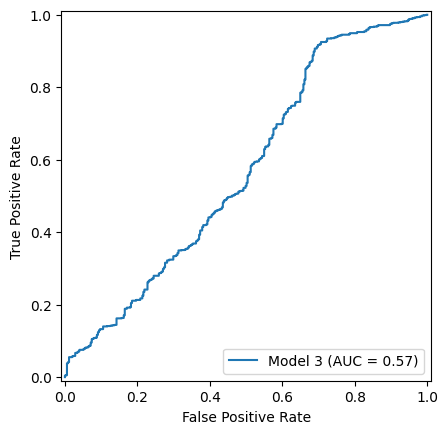

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_true_diag_c25_t, y_prob_diag_c25_t)

roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Model 3')
display.plot()

# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



In [33]:
# no code is required for this section
'''
The repo that is provided is missing key elements of the code such as - 'dataset.py' and 'tokenier' information. 
Also when trying to use pretrained 'tokenizer' and 'pretrained' model, it is producing access error (401).
In the original papaer it emphasizes and uses use cases for 'Pancreatic Cancer' and international 'PTSD'. 
The dataset that we are using has less samples. Due to that reason we think result of the paper is not reproducible.

'''



"\nThe repo that is provided is missing key elements of the code such as - 'dataset.py' and 'tokenier' information. \nAlso when trying to use pretrained 'tokenizer' and 'pretrained' model, it is producing access error (401).\nIn the original papaer it emphasizes and uses use cases for 'Pancreatic Cancer' and international 'PTSD'. \nThe dataset that we are using has less samples. Due to that reason we think result of the paper is not reproducible.\n\n"

# References

1.   Yang, Z., Mitra, A., Liu, W. et al. TransformEHR: transformer-based encoder-decoder generative model to enhance prediction of disease outcomes using electronic health records. Nat Commun 14, 7857 (2023). https://doi.org/10.1038/s41467-023-43715-z



# Feel free to add new sections